In [16]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# import cleaned data

In [2]:
MAX_SESSION_DURATION = 1
id_counter = 0

# parsing timestamps into python timestamps
def parse_timestamp(time):
    if type(time) is str:
        time = time.split('.')[0]
        return pd.Timestamp(time)

# Converting test passed/total to integer as it has to be a integer value.
# nan values are converted to -1, this is subject to change (we might just delete them?)
def to_int(value):
    try:
        return int(value)
    except:
        return -1

def clean_build_events():
    df = import_data('../data/','buildEvents.csv')
    df['timestamp'] = df['timestamp'].apply(parse_timestamp)
    
    # dict = build_dictionary(df)
    return df

def clean_edit_events():
    df = import_data('../data/','editEvents.csv')
    df['timestamp'] = df['timestamp'].apply(parse_timestamp)
    return df

    

def clean_test_events():
    df = import_data('../data/','testEvents.csv')
    df['timestamp'] = df['timestamp'].apply(parse_timestamp)

    df['totalTests'] = df['totalTests'].apply(to_int)
    df['testsPassed'] = df['testsPassed'].apply(to_int)
    return df

    
def build_dictionary(df):
    dict = {}
    for index, row in df.iterrows():
        #check if session id is registered
        if row['sessionID'] in dict:
            dict[row['sessionID']].append(row[1:])
        else:
            dict[row['sessionID']] = []
    return dict

def generate_id():
    global id_counter
    old_id = id_counter
    id_counter +=1
    return old_id

def select_and_merge(df1, df2, df3):
    return pd.concat([df1[['sessionID', 'timestamp']], df2[['sessionID', 'timestamp']], df3[['sessionID', 'timestamp']]])

def update_id(dfs, id, timestamp, new_id):
    for df in dfs:
        print(f'updating df')
        print(f'row: {df.loc[(df["sessionID"] == id) & (df["timestamp"] == timestamp), "sessionID"]}' )
        df.loc[(df['sessionID'] == id) & (df['timestamp'] == timestamp), 'sessionID'] = new_id
        print(f'row: {df.loc[(df["sessionID"] == new_id) & (df["timestamp"] == timestamp), "sessionID"]}' )


    return (dfs[0], dfs[1], dfs[2])

# todo: figure out splitting logic
def split_long_sessions(df1, df2, df3):
    df = select_and_merge(df1, df2, df3)
    df = df.sort_values(by=['sessionID', 'timestamp'])
    print(df.head())
    # initial id of each session
    initial_id = df['sessionID'].iloc(0)
    # start of each session
    session_start = df['timestamp'].iloc(0)
    new_id = None
    is_split = False
    test_index = 0
    for index, row in df.iterrows():
        if test_index > 10:
            return (df1, df2, df3)
        test_index += 1

        # true as long as we are considering rows that originate from the same session
        if row['sessionID'] == initial_id:
            # check if we have previously split up this session
            if is_split:
                df1, df2, df3 = update_id([df1, df2, df3], row['sessionID'], row['timestamp'], new_id)
                row['sessionID'] = new_id
                df.loc[index, 'sessionID'] = new_id
                
            difference = (row['timestamp'] - session_start).seconds / 60
            if difference >= MAX_SESSION_DURATION:
                
                is_split = True
                new_id = generate_id()
                df1, df2, df3 = update_id([df1, df2, df3], row['sessionID'], row['timestamp'], new_id)
                df.loc[index, 'sessionID'] = new_id

                session_start = row['timestamp']
        # completely new session
        else:
            initial_id = row['sessionID']
            session_start = row['timestamp']
            new_id = None
            is_split = False
    
    return (df1, df2, df3)





def import_data(path, filename):
    return pd.read_csv(os.path.join(path, filename))
    
    
df_build = clean_build_events()
df_edit = clean_edit_events()
df_test = clean_test_events()
# print(df.head(10))
df_build, df_edit, df_test = split_long_sessions(df_build, df_edit, df_test)
df_build = df_build.sort_values(by=['sessionID', 'timestamp'])
df_edit = df_edit.sort_values(by=['sessionID', 'timestamp'])
df_test = df_test.sort_values(by=['sessionID', 'timestamp'])

                                   sessionID           timestamp
474138  0001efd9-3849-481a-86bd-afd47037efb9 2016-10-04 14:34:41
474139  0001efd9-3849-481a-86bd-afd47037efb9 2016-10-04 14:35:21
14061   0001efd9-3849-481a-86bd-afd47037efb9 2016-10-04 14:35:55
474140  0001efd9-3849-481a-86bd-afd47037efb9 2016-10-04 14:36:01
14062   0001efd9-3849-481a-86bd-afd47037efb9 2016-10-04 14:36:07
updating df
row: 14061    0001efd9-3849-481a-86bd-afd47037efb9
Name: sessionID, dtype: object
row: 14061    0
Name: sessionID, dtype: object
updating df
row: Series([], Name: sessionID, dtype: object)
row: Series([], Name: sessionID, dtype: object)
updating df
row: Series([], Name: sessionID, dtype: object)
row: Series([], Name: sessionID, dtype: object)
updating df
row: Series([], Name: sessionID, dtype: object)
row: Series([], Name: sessionID, dtype: object)
updating df
row: 474140    0001efd9-3849-481a-86bd-afd47037efb9
Name: sessionID, dtype: object
row: 474140    0
Name: sessionID, dtype: object
up

In [3]:
df_build.describe()

,sessionID,timestamp,buildSuccessful
count,14957,14956,14956
unique,1531,14877,2
top,26f3dadd-c2e3-414b-8c92-78df1dc356c8,2016-07-17 12:14:35,True
freq,154,2,12889
first,NaN,2016-03-20 12:33:59,NaN
last,NaN,2017-02-23 22:03:36,NaN


In [4]:
#we can easily ignore sessions that don't contain build events since we only care about build events
sessionIDs = df_build.sessionID.unique()
sessionIDs

array([0, 1, '0001efd9-3849-481a-86bd-afd47037efb9', ...,
       'ffb030c9-c0ff-42bd-9e04-6c4b44f5ab79',
       'ffc444d0-8382-4e52-9f04-3c42601ec739',
       'ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f'], dtype=object)

# create dataset

here we build our dataset for the analysis:
* find the session beginnings
* collect time between last build (or session beginning) and next build

### find session beginnings
it's ok to just look at the editEvents because a) it's unlikely that a build happened before an edit and b) if a build happened before the first edit, it's success does not depend on this session anyways

In [5]:
grouped = df_edit.groupby(['sessionID'])
sessionStarts = grouped.agg({'timestamp':np.min}).to_dict()
sessionStarts['timestamp']['0001efd9-3849-481a-86bd-afd47037efb9']

Timestamp('2016-10-04 14:34:41')

In [6]:
#build events are ordered by session id and timestamp
previous = {'sessionID': 'nonexistent-atsirtsakitaiea'}
time_to_build = []
for _, event in df_build.iterrows():
    try:
        if previous['sessionID'] == event['sessionID']:
            begin = previous['timestamp']
        else:
            begin = sessionStarts['timestamp'][event['sessionID']]
        end = event['timestamp']
        duration = pd.Timedelta(end-begin).seconds
        time_to_build.append((duration,event['buildSuccessful']))
    except Exception:
        #nothing
        ;
    previous = event
time_to_build

[(86394, False),
 (12, False),
 (43, False),
 (3, False),
 (0, True),
 (146, False),
 (520, True),
 (3331, True),
 (2154, True),
 (572, True),
 (1795, True),
 (216, True),
 (50, True),
 (1154, True),
 (1683, True),
 (1493, True),
 (188, True),
 (451, True),
 (204, True),
 (114, True),
 (310, True),
 (146, True),
 (51, True),
 (265, False),
 (137, False),
 (116, False),
 (119, False),
 (52, True),
 (176, True),
 (94, True),
 (42, True),
 (194, True),
 (170, True),
 (38, True),
 (90, False),
 (37, True),
 (90, True),
 (196, True),
 (93, True),
 (82, True),
 (138, True),
 (405, True),
 (70, True),
 (412, True),
 (289, True),
 (26, True),
 (2711, True),
 (544, False),
 (50, False),
 (100, True),
 (19, True),
 (114, False),
 (24, False),
 (27, False),
 (57, False),
 (61, False),
 (8, False),
 (8, False),
 (74, False),
 (301, True),
 (81287, True),
 (9707, False),
 (20, True),
 (30, True),
 (79399, True),
 (42, True),
 (15, True),
 (10, True),
 (35, True),
 (11, True),
 (4056, True),
 (524, 

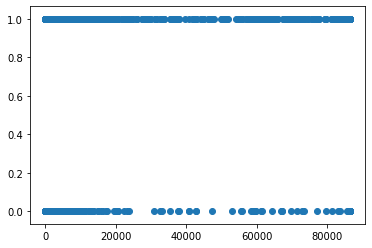

In [18]:
times = [x[0] for x in time_to_build]
passes = [int(x[1]) for x in time_to_build]

plt.scatter(times, passes)

In [27]:
model = np.polyfit(times, passes, 1)
model

array([-9.59008448e-07,  8.63908769e-01])

In [28]:
from sklearn.metrics import r2_score
predict = np.poly1d(model)
r2_score(passes, predict(times))

0.0008954898798043676